# Fitting to get the powder average coefficients.
After fitting CF eigenvalues to neutron data the susceptibility as calculated by PCF is orders of magnitude off of our measurements. Turns out PCF does powder averaging by summing in all three directions then dividing by 3. This is a commonly used tool.
However, with our systems g-tensor the g<sub>xx</sub> = g<sub>yy</sub> > g<sub>zz</sub> by almost 3 times. 

[This paper](https://arxiv.org/ftp/arxiv/papers/1312/1312.2401.pdf) demonstrates that 1/3 factor may not be true for all systems.

I decide to fit predicted magnetization to measurements by allowing the coefficients for each magnetization direction to vary. After this magnetization fitting we gather the prefactors that properly scales PCF's prediction.

In [65]:
import sys
sys.path.append('..')
from JensenTools import *
import seaborn as sns
sns.set()

## Declare important variables.

In [66]:
# Define important things
#####################################################################################################################################################################
comp = 'Sr2PrO4'
who = 'Arun'
ion = 'Ce3+'
LS_on = False
per = 'spin'
molweight = molweight[comp]

# The L,S values are as follows for the Pr4+ ion
L = 3
S = 0.5
#####################################################################################################################################################################

## LMFIT Model for fitting coefficients of powder averaging

In [67]:
# Function to be made into an LMFIT model.
def magFit(Pr,Ha,T,a,b,c, **kwargs ):
    mag = []
    if kwargs['LS_on']:
        for i in T:
            mag.append(a*Pr.magnetization(Temp = i, Field = [Ha, 0, 0])[0] + b*Pr.magnetization(Temp = i, Field = [0, Ha, 0])[1] + c*Pr.magnetization(Temp = i, Field = [0, 0, Ha])[2])
    else:
        for i in T:
            mag.append(a*Pr.magnetization(Temp = i, Field = [Ha, 0, 0], ion = ion)[0] + b*Pr.magnetization(Temp = i, Field = [0, Ha, 0], ion = ion)[1] + c*Pr.magnetization(Temp = i, Field = [0, 0, Ha], ion = ion)[2])
    
    return -Ha/np.array(mag)

## Best fit Stevens coefficients from fitting to energy

In [68]:
#Best Fit LS
#####################################################################################################################################################################
if LS_on:	
	B40  =  -0.6568663783690575
	B60  =  -0.02328250024945387
	LS  =  100.00007580463522
	B44  =  -3.1415463304732714
	B64  =  0.504906552605772
	B20  =  0.4858075931009187
#####################################################################################################################################################################

# Best Fit J
#####################################################################################################################################################################
if not LS_on:
	# # Red Chi = ~.01
	B40  =  -0.5572886105373519
	B60  =  0.4673
	B44  =  -3.0946858584804335
	B64  =  -9.8133
	B20  =  12.606195720794622
#####################################################################################################################################################################

# Create Pr CFLevels object using the best fit coefficients.
#####################################################################################################################################################################
stev = { 'B20' :B20, 'B40': B40, 'B44' : B44, 'B60': B60, 'B64' : B64 }
#Create the CFLevels object and diagonalize it
if LS_on:
	Pr = cef.LS_CFLevels.Bdict(Bdict = stev, L = L, S = S, SpinOrbitCoupling=LS)
	Pr.diagonalize()
else:
	Pr = cef.CFLevels.Bdict(Bdict = stev, ion = ion)
	Pr.diagonalize()
#####################################################################################################################################################################

## Loading M vs H measured data and choosing a temperature run.

In [69]:
saveDir = getSaveDir('m',comp = comp) #General Directory for the project
MTDir = getSaveDir('m',comp = comp, dataType = 'MT') #MvsT data
MHDir = getSaveDir('m',comp = comp, dataType = 'MH') #MvsH data 

# Loading data for M vs T 
#####################################################################################################################################################################
runs = []
for i in os.listdir(MTDir):
    if i.endswith('.DAT') or i.endswith('.dat'): #This was a safeguard against a situation arising at an earlier implementation of my code.
        runs.append(i)
for i in runs:
    M,H,T,MErr,mass,measType = getData(i,MTDir, who = who, dataType = 'MT')
    M = normalize(M,mass,molweight,per)
    MErr = normalize(MErr,mass,molweight,per)
    MTdata[measType] = [M,H,T,MErr,mass]
    
runs = []
for i in os.listdir(MHDir):
    if i.endswith('.DAT'): #This was a safeguard against a situation arising at an earlier implementation of my code.
        runs.append(i)
MHdata = {}
for i in runs:
    M, H, Err, mass, T = getData(i,MHDir,who = who, dataType = 'MH')
    M = normalize(M,mass,molweight, per)
    Err = normalize(Err,mass,molweight, per)
    MHdata[T] = [M,H,Err,mass,i]

#Either 'ZFC' or 'FC'
M,H,T,MErr,mass = MTdata['FC']

MBohr = emuToBohr2(M)
HTes = oeToTesla(H)
X = MBohr/HTes
Xi = 1/X

## Fit the model to data allowing powder average coefficients to vary.

In [70]:
# Make LMFIT model and fit
# Create stevens coefficients dictionary from fitted parameters
#####################################################################################################################################################################
magModel = Model(magFit, independent_vars = ['Ha', 'Pr', 'T'])
params = magModel.make_params()

# Bounded
params['a'].set(value = 1/3, min = .0001, max = 1)
params['b'].set(value = 1/3, min = .0001, max = 1)
params['c'].set(value = 1/3, min = .0001, max = 1)

## Unbounded
# params['a'].set(value = 1/3)
# params['b'].set(value = 1/3)
# params['c'].set(value = 1/3)

# Fit model to data
Ha = .1
XFitted = magModel.fit(Xi,params,Pr = Pr, Ha = Ha, T = T, LS_on = LS_on, ion = ion)
XFitted.params.pretty_print()


Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
a   0.06701   0.0001        1 6.388e+04     True     None     None
b   0.06701   0.0001        1 6.388e+04     True     None     None
c    0.0001   0.0001        1   0.2656     True     None     None


## Plot

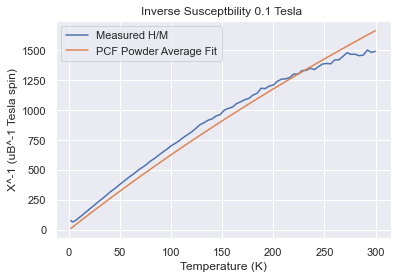

In [71]:
plt.figure()
plt.plot(T,Xi, label = 'Measured H/M')
plt.plot(T,XFitted.best_fit, label = 'PCF Powder Average Fit')
plt.xlabel('Temperature (K)')
plt.ylabel('X^-1 (uB^-1 Tesla spin)')
plt.legend()
plt.title('Inverse Susceptbility {} Tesla '.format(.1))
plt.show()

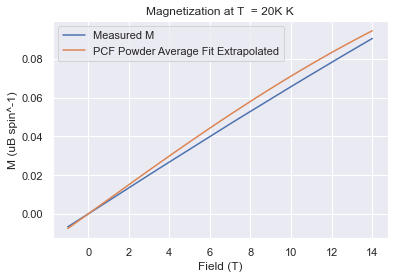

In [72]:
# Choosing 20K run
T = '20K'
Temp = getTemp(MHdata[T][-1], who = who)
M, H, Err, mass, filename = MHdata[T]
M = emuToBohr2(M)
H = oeToTesla(H)

mag = []
for i in H:
    if LS_on:
        mag.append(XFitted.params['a']*Pr.magnetization(Temp = Temp, Field = [i, 0, 0])[0] + XFitted.params['a']*Pr.magnetization(Temp = Temp, Field = [0, i, 0])[1] + XFitted.params['c']*Pr.magnetization(Temp = Temp, Field = [0, 0, i])[2])
    else:
        mag.append(XFitted.params['a']*Pr.magnetization(Temp = Temp, Field = [i, 0, 0], ion=ion)[0] + XFitted.params['a']*Pr.magnetization(Temp = Temp, Field = [0, i, 0], ion = ion)[1] + XFitted.params['c']*Pr.magnetization(Temp = Temp, Field = [0, 0, i], ion = ion)[2])

mag = -1*np.array(mag)

plt.figure()
plt.plot(H,M, label = 'Measured M')
plt.plot(H, mag , label = 'PCF Powder Average Fit Extrapolated')
plt.xlabel('Field (T)')
plt.ylabel('M (uB spin^-1)')
plt.legend()
plt.title('Magnetization at T  = {} K'.format(T))
plt.show()